# Install

In [27]:
!pip install umap

In [28]:
!pip install umap-learn

# Importing the used libraries

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
import tensorflow as tf
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import umap
from sklearn.preprocessing import StandardScaler

# BuckyNet

In [30]:
class BuckyNet:
    def __init__(self,
                 inputs,
                 outputs,
                 dim_matrix,
                 num_nondim,
                 num_layers,
                 num_neurons,
                 activation,
                 initializer,
                 nepoch,
                 patience,
                 test_size,
                 l1_reg,
                 l2_reg,
                 adamlr,
                 verbose,
                 nullspace_loss,
                 normalize=False):

        self.inputs_train, self.inputs_test, self.outputs_train, self.outputs_test = \
            train_test_split(np.log(inputs), outputs, test_size=test_size, shuffle=False)
        self.inputs_train, self.inputs_dev, self.outputs_train, self.outputs_dev = \
                train_test_split(self.inputs_train, self.outputs_train, test_size=test_size, shuffle=False)
        self.dim_matrix = dim_matrix
        self.num_nondim = num_nondim
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.initializer = initializer
        self.nepoch = nepoch
        self.patience = patience
        self.nullspace_loss = nullspace_loss
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.adamlr = adamlr
        self.normalize = normalize
        self.verbose = verbose
        self.model = self.build_model()
        self.history = None

    def cross_validate(self, n_splits=10):
        kfold = KFold(n_splits=n_splits, shuffle=True)
        scores = []

        for train_index, test_index in kfold.split(self.inputs_train):

            X_train, X_val = self.inputs_train[train_index], self.inputs_train[test_index]
            Y_train, Y_val = self.outputs_train[train_index], self.outputs_train[test_index]
            self.model = self.build_model()

            self.model.fit(X_train, Y_train,
                           validation_data=(X_val, Y_val),
                           epochs=self.nepoch,
                           verbose=self.verbose,
                           callbacks=[keras.callbacks.EarlyStopping(patience=self.patience)])

            score = self.model.evaluate(self.inputs_test, self.outputs_test)
            scores.append(score)

        return scores


    def build_model(self):
        input_layer = keras.layers.Input(shape=[self.inputs_train.shape[1]], name='inputs')
        pi_layer = keras.layers.Dense(self.num_nondim, activation='exponential', kernel_initializer=self.initializer,
                kernel_regularizer=keras.regularizers.l1_l2(self.l1_reg, self.l2_reg), use_bias=False, name='pi_numbers')(input_layer)
        layer = pi_layer
        for i in range(self.num_layers):
            layer = keras.layers.Dense(self.num_neurons, activation=self.activation, kernel_initializer=self.initializer,
                    kernel_regularizer=keras.regularizers.l2(self.l2_reg),
                    bias_regularizer=keras.regularizers.l2(self.l2_reg), name='layer_'+str(i+1))(layer)

        if len(self.outputs_train.shape) > 1:
            outlayers = self.outputs_train.shape[1]
        else:
            outlayers = 1
        output_layer = keras.layers.Dense(outlayers, activation='linear', name='outputs',
                            kernel_initializer=self.initializer,
                            kernel_regularizer=keras.regularizers.l2(self.l2_reg),
                            bias_regularizer=keras.regularizers.l2(self.l2_reg))(layer)


        model = keras.Model(inputs=input_layer, outputs=[output_layer])
        optimizer = keras.optimizers.Adam(lr=self.adamlr)
        model.compile(loss='mse', optimizer=optimizer, metrics=[[keras.metrics.RootMeanSquaredError()]])

        if self.nullspace_loss is not None:
            P = tf.constant(self.dim_matrix, dtype=tf.float32)
            model.add_loss(lambda: self.nullspace_loss * tf.reduce_mean(tf.square( tf.matmul(P, model.layers[1].kernel))) )

        return model

    def single_run(self):
        eval_loss = self.loss()
        weights = self.model.layers[1].get_weights()[0]
        return weights

    def loss(self):
        self.history = self.model.fit(self.inputs_train, self.outputs_train,
                                validation_data=(self.inputs_dev, self.outputs_dev),
                                epochs=self.nepoch, verbose=self.verbose, callbacks=[keras.callbacks.EarlyStopping(patience=self.patience)])
        lossval = self.model.evaluate(self.inputs_test, self.outputs_test)
        return lossval

# Control model

In [31]:
class NeuralNet:
    def __init__(self,
                inputs,
                outputs,
                num_layers,
                num_neurons,
                activation,
                initializer,
                nepoch,
                patience,
                test_size,
                l1_reg,
                l2_reg,
                adamlr,
                verbose,
                normalize = False):

        self.inputs_train, self.inputs_test, self.outputs_train, self.outputs_test = \
            train_test_split(inputs, outputs, test_size=test_size, shuffle=False)
        self.inputs_train, self.inputs_dev, self.outputs_train, self.outputs_dev = \
                train_test_split(self.inputs_train, self.outputs_train, test_size=test_size, shuffle=False)
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.initializer = initializer
        self.nepoch = nepoch
        self.patience = patience
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.adamlr = adamlr
        self.normalize = normalize
        self.verbose = verbose
        self.model = self.build_model()
        self.history = None

    def cross_validate(self, n_splits=10):
        kfold = KFold(n_splits=n_splits, shuffle=True)
        scores = []

        for train_index, test_index in kfold.split(self.inputs_train):
            X_train, X_val = self.inputs_train[train_index], self.inputs_train[test_index]
            Y_train, Y_val = self.outputs_train[train_index], self.outputs_train[test_index]

            self.model = self.build_model()

            self.model.fit(X_train, Y_train,
                           validation_data=(X_val, Y_val),
                           epochs=self.nepoch,
                           verbose=self.verbose,
                           callbacks=[keras.callbacks.EarlyStopping(patience=self.patience)])

            score = self.model.evaluate(self.inputs_test, self.outputs_test)
            scores.append(score)

        return scores

    def build_model(self):
        input_layer = keras.layers.Input(shape=[self.inputs_train.shape[1]], name='inputs')
        layer = input_layer
        for i in range(self.num_layers):
            layer = keras.layers.Dense(self.num_neurons, activation=self.activation, kernel_initializer=self.initializer,
                    kernel_regularizer=keras.regularizers.l2(self.l2_reg),
                    bias_regularizer=keras.regularizers.l2(self.l2_reg), name='layer_'+str(i+1))(layer)

        if len(self.outputs_train.shape) > 1:
            outlayers = self.outputs_train.shape[1]
        else:
            outlayers = 1
        output_layer = keras.layers.Dense(outlayers, activation='linear', name='outputs',
                            kernel_initializer=self.initializer,
                            kernel_regularizer=keras.regularizers.l2(self.l2_reg),
                            bias_regularizer=keras.regularizers.l2(self.l2_reg))(layer)


        model = keras.Model(inputs=input_layer, outputs=[output_layer])
        optimizer = keras.optimizers.Adam(lr=self.adamlr)
        model.compile(loss='mse', optimizer=optimizer, metrics=[[keras.metrics.RootMeanSquaredError()]])

        return model

    def loss(self):
        self.history = self.model.fit(self.inputs_train, self.outputs_train,
                                validation_data=(self.inputs_dev, self.outputs_dev),
                                epochs=self.nepoch, verbose=self.verbose, callbacks=[keras.callbacks.EarlyStopping(patience=self.patience)])
        lossval = self.model.evaluate(self.inputs_test, self.outputs_test)
        return lossval

# Simple harmonic oscillator model

## Construct the model

In [32]:
class HarmonicOscillator:
    def __init__(self, nsamples=int(1e2), time_steps=500, tend=100, initial_condition=[1, 0], seed = 1):
        self.nsamples = nsamples
        self.time_steps = time_steps
        self.tend = tend
        self.initial_condition = initial_condition
        self.seed = seed

    def get_data(self):
        np.random.seed(self.seed)
        m = np.random.uniform(0.5, 1.5, self.nsamples)  # Mass
        k = np.random.uniform(0.1, 1, self.nsamples)  # Spring constant
        t = np.linspace(0, self.tend, self.time_steps)
        p = np.vstack([m, k]).T

        x = self.solve(m, k, t)
        return p, x

    def solve(self, m, k, t):
        x = np.zeros([self.nsamples, len(t)])
        for i in range(self.nsamples):
            x[i, :] = self.run_sim(m[i], k[i], t)[:, 0]
        return x

    def run_sim(self, m, k, t):
        return odeint(lambda y, t: self.rhs(y, m, k), self.initial_condition, t)

    def rhs(self, y, m, k):
        return [y[1], -k/m*y[0]]

    def get_dim_matrix(self):
        Pi = np.array([[1, 0],
                      [1, -2]]).T
        return Pi

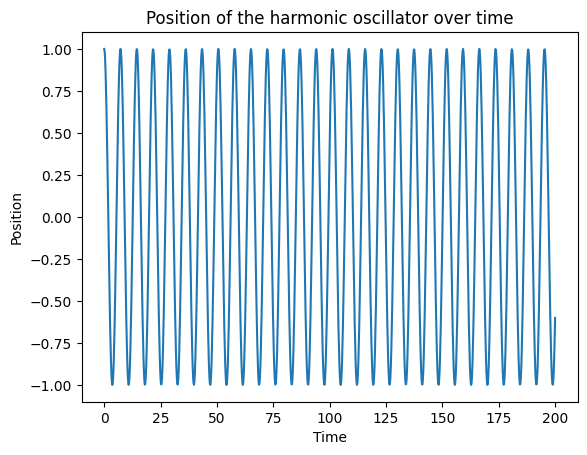

In [33]:
nsamples = int(6e3)
tsteps = 1000
tend = 200
initial_condition = [1, 0]

# Create an instance of the HarmonicOscillator class
R = HarmonicOscillator(nsamples=nsamples, time_steps=tsteps, tend=tend, initial_condition=initial_condition, seed = 1)

# Generate data using the get_data method
X, Y = R.get_data()

# Get Dimensional Matrix
dim_matrix = R.get_dim_matrix()

# Select the first set of data
x_sample = Y[0, :]
t = np.linspace(0, R.tend, R.time_steps)

# Draw the image
plt.figure()
plt.plot(t, x_sample)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position of the harmonic oscillator over time')
plt.show()

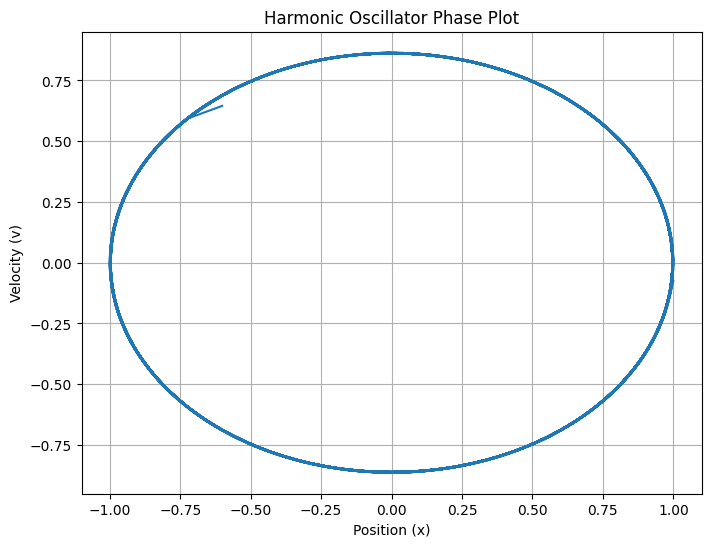

In [34]:
t = np.linspace(0, tend, tsteps)

plt.figure(figsize=(8,6))
plt.plot(Y[0, :], np.gradient(Y[0, :], t))
plt.title("Harmonic Oscillator Phase Plot")
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
plt.grid(True)
plt.show()

## Training Modle

### BuckyNet

In [37]:
model = BuckyNet(X, Y, dim_matrix, num_nondim=1, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0, nullspace_loss = 0.0001)
loss = model.loss()

print("loss",loss)

29/29 [==============================] - 0s 2ms/step - loss: 0.3370 - root_mean_squared_error: 0.5686
loss [0.3370087742805481, 0.5686103701591492]


### Control Model

In [33]:
model1 = NeuralNet(X, Y, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0)

loss1 = model1.loss()

print("Cross-validation scores:", loss1)

29/29 [==============================] - 0s 3ms/step - loss: 0.6352 - root_mean_squared_error: 0.7882
Cross-validation scores: [0.6351549625396729, 0.7881910800933838]


### UMAP Output Results Training Control Modle

Dimensionality reduction

In [38]:
x = umap.UMAP(n_components=1).fit(X)

x_trian = x.embedding_

Training Modle

In [39]:
model2 = NeuralNet(x_trian, Y, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0)

loss2 = model2.loss()

print("Cross-validation scores:", loss2)

29/29 [==============================] - 0s 2ms/step - loss: 0.4875 - root_mean_squared_error: 0.6921
Cross-validation scores: [0.48754024505615234, 0.6921151876449585]


## Cross-validation performance impact

### Buckynet

In [35]:
# gradient clipping
optimizer = keras.optimizers.Adam(lr=0.01, clipnorm=1.0)

model = BuckyNet(X, Y, dim_matrix, num_nondim=1, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0, nullspace_loss = 0.0001)
scores = model.cross_validate(n_splits=5)

print("Cross-validation scores:", scores)

29/29 [==============================] - 0s 3ms/step - loss: 0.4241 - root_mean_squared_error: 0.6468


29/29 [==============================] - 0s 2ms/step - loss: 0.3375 - root_mean_squared_error: 0.5727


29/29 [==============================] - 0s 2ms/step - loss: 0.4863 - root_mean_squared_error: 0.6925


29/29 [==============================] - 0s 2ms/step - loss: 0.3103 - root_mean_squared_error: 0.5412


29/29 [==============================] - 0s 3ms/step - loss: 0.3707 - root_mean_squared_error: 0.6027
Cross-validation scores: [[0.42409130930900574, 0.6468068361282349], [0.33750811219215393, 0.5727058053016663], [0.48631414771080017, 0.692542552947998], [0.31029212474823, 0.5411832928657532], [0.3707292377948761, 0.6027417182922363]]


### Control model

In [36]:
model1 = NeuralNet(X, Y, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0)

scores1 = model1.cross_validate(n_splits=5)

print("Cross-validation scores:", scores1)

29/29 [==============================] - 0s 2ms/step - loss: 0.5905 - root_mean_squared_error: 0.7610


29/29 [==============================] - 0s 2ms/step - loss: 0.5988 - root_mean_squared_error: 0.7667


29/29 [==============================] - 0s 2ms/step - loss: 0.5921 - root_mean_squared_error: 0.7620


29/29 [==============================] - 0s 3ms/step - loss: 0.6242 - root_mean_squared_error: 0.7840


29/29 [==============================] - 0s 2ms/step - loss: 0.5955 - root_mean_squared_error: 0.7637
Cross-validation scores: [[0.5905289649963379, 0.7610151767730713], [0.5987583994865417, 0.7666963934898376], [0.5920558571815491, 0.7620007395744324], [0.624163806438446, 0.7840127944946289], [0.5955156087875366, 0.7636545300483704]]


## Verifying robustness and generalisation with noisy data

Get new data

In [35]:
R1 = HarmonicOscillator(nsamples=nsamples, time_steps=tsteps, tend=tend, initial_condition=initial_condition, seed = 100)

X2, Y2 = R1.get_data()

Adding Gaussian Noise

In [36]:
X_noise = X2 + np.random.normal(loc=0.0, scale=0.2, size=X.shape)

### BuckyNet

In [89]:
from sklearn.metrics import mean_squared_error

predictions1 = model.model.predict(X_noise)

mse_value1 = mean_squared_error(predictions1, Y2)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

188/188 [==============================] - 0s 1ms/step
MSE 0.5852018523810939
RMSE 0.764984870687711


### Control Model

In [116]:
from sklearn.metrics import mean_squared_error

predictions1 = model1.model.predict(X_noise)

mse_value1 = mean_squared_error(predictions1, Y2)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

188/188 [==============================] - 1s 3ms/step
MSE 0.6612785146853581
RMSE 0.8131903311558483


### UMPA

Dimensionality reduction

In [25]:
x = umap.UMAP(n_components=1).fit(X)

x_trian = x.embedding_

test_embedding = x.transform(X_noise)

x_test = test_embedding

In [26]:
from sklearn.metrics import mean_squared_error

predictions1 = model2.model.predict(x_test)

mse_value1 = mean_squared_error(predictions1, Y2)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

188/188 [==============================] - 0s 2ms/step
MSE 0.49770694288133743
RMSE 0.705483481650235


## Data visualisation

### BuckyNet processed embedding space

Raw Data

In [57]:
from keras.models import Model

model10 = BuckyNet(X2, Y2, dim_matrix, num_nondim=1, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=1, nullspace_loss = 0.0001)

# Create a new model with output from Pi_layer
New_model = Model(inputs=model10.model.inputs,
                           outputs=model10.model.get_layer('pi_numbers').output)

# Use the new model to predict the input data and get the output of Pi_layer
Pi_outputs = New_model.predict(model10.inputs_train)


136/136 [==============================] - 0s 1ms/step


Noisy Data

In [49]:
model11 = BuckyNet(X_noise, Y2, dim_matrix, num_nondim=1, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=1, nullspace_loss = 0.0001)

# Create a new model with output from Pi_layer
New_model1 = Model(inputs=model11.model.inputs,
                           outputs=model11.model.get_layer('pi_numbers').output)

# Use the new model to predict the input data and get the output of Pi_layer
Pi_outputs1 = New_model1.predict(model11.inputs_train)

<ipython-input-30-900551f4a106>:22: RuntimeWarning: invalid value encountered in log
  train_test_split(np.log(inputs), outputs, test_size=test_size, shuffle=False)


136/136 [==============================] - 0s 1ms/step


Histogram

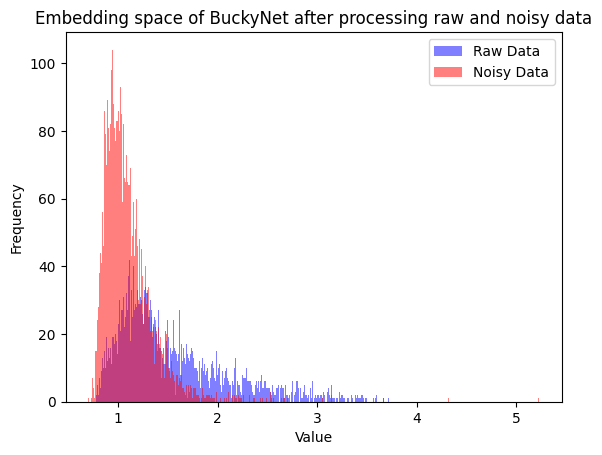

In [58]:
plt.hist(Pi_outputs, bins=500, alpha=0.5, label='Raw Data', color='blue')
plt.hist(Pi_outputs1, bins=500, alpha=0.5, label='Noisy Data', color='red')

plt.legend(loc='upper right')

plt.title('Embedding space of BuckyNet after processing raw and noisy data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Embedding space after UMAP dimensionality reduction

In [59]:
x2 = umap.UMAP(n_components=1).fit(X2)

x_trian2 = x2.embedding_

test_embedding2 = x2.transform(X_noise)

x_test2 = test_embedding2

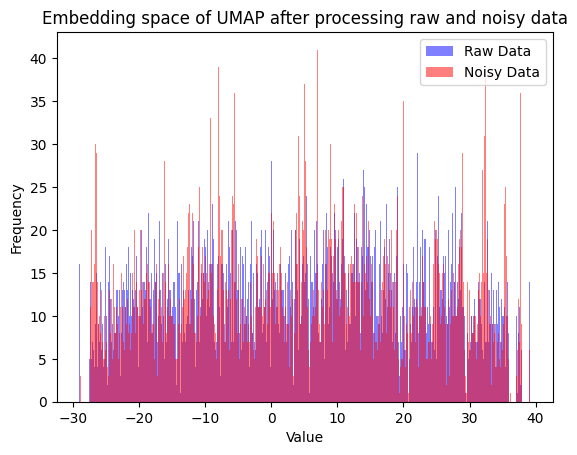

In [60]:
plt.hist(x_trian2, bins=500, alpha=0.5, label='Raw Data', color='blue')
plt.hist(x_test2, bins=500, alpha=0.5, label='Noisy Data', color='red')

plt.legend(loc='upper right')

plt.title('Embedding space of UMAP after processing raw and noisy data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Damped Driven Oscillator Model

## construct the model

In [61]:
class DampedDrivenOscillator:
    def __init__(self, nsamples=int(1e2), tsteps = 10, tend=200, initial_condition=[1, 0], seed = 3):
        self.nsamples = nsamples
        self.tsteps = tsteps
        self.tend = tend
        self.initial_condition = initial_condition
        self.seed = seed

    def get_data(self):
        np.random.seed(self.seed)
        m = np.random.uniform(1, 2, self.nsamples)  # Mass
        k = np.random.uniform(5, 6, self.nsamples)  # Spring constant
        b = np.random.uniform(0.2, 0.3, self.nsamples)  # Damping coefficient
        F = np.random.uniform(0.1, 0.2, self.nsamples)  # Amplitude of external force
        w = np.random.uniform(0.1, 0.2, self.nsamples)  # Frequency of external force
        t = np.linspace(0, self.tend, self.tsteps)
        p = np.vstack([m, k, b, F, w]).T

        x = self.solve(m, k, b, F, w, t)
        return p, x

    def solve(self, m, k, b, F, w, t):
        x = np.zeros([self.nsamples, len(t)])
        for i in range(self.nsamples):
            x[i, :] = self.run_sim(m[i], k[i], b[i], F[i], w[i], t)[:, 0]
        return x

    def run_sim(self, m, k, b, F, w, t):
        return odeint(lambda y, t: self.rhs(y, m, k, b, F, w, t), self.initial_condition, t)

    def rhs(self, y, m, k, b, F, w, t):
        return [y[1], F/m*np.cos(w*t) - k/m*y[0] - b/m*y[1]]

    def get_dim_matrix(self):
        Pi = np.array([[1, 0, 0], [1, 0, -2], [1, 0 , -1], [1, 1 , -2], [0, 0, -1]]).T
        return Pi

Drawing the image

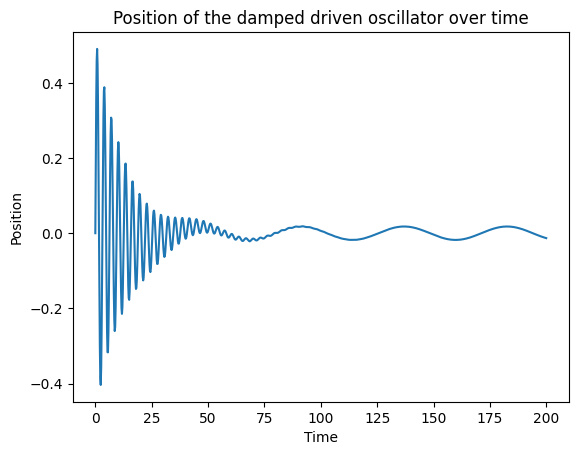

In [62]:
nsamples = int(6e3)
tsteps = 1000
tend = 200
initial_condition = [0, 1]
seed = 1

# Create an instance of the DampedDrivenOscillator class
R2 = DampedDrivenOscillator(nsamples=nsamples, tsteps=tsteps, tend=tend, initial_condition=initial_condition, seed = seed)

# Generate data using the get_data method
X1, Y1 = R2.get_data()

dim_matrix1 = R2.get_dim_matrix()

# Select the first set of data
x_sample = Y1[0, :]
t = np.linspace(0, R2.tend, R2.tsteps)

# Draw the image
plt.figure()
plt.plot(t, x_sample)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position of the damped driven oscillator over time')
plt.show()

In [63]:
Y1

array([[ 0.        ,  0.19350611,  0.35415167, ..., -0.01236088,
        -0.01271088, -0.01305124],
       [ 0.        ,  0.19414868,  0.35934569, ..., -0.00806796,
        -0.00761154, -0.00715098],
       [ 0.        ,  0.19098552,  0.33585853, ...,  0.01848653,
         0.01881936,  0.01914083],
       ...,
       [ 0.        ,  0.19162086,  0.34165867, ..., -0.02697691,
        -0.0268486 , -0.02669846],
       [ 0.        ,  0.19576317,  0.36895441, ..., -0.00130401,
        -0.0023951 , -0.0034824 ],
       [ 0.        ,  0.19437308,  0.3592953 , ...,  0.01760985,
         0.01825725,  0.01888751]])

Phase diagram

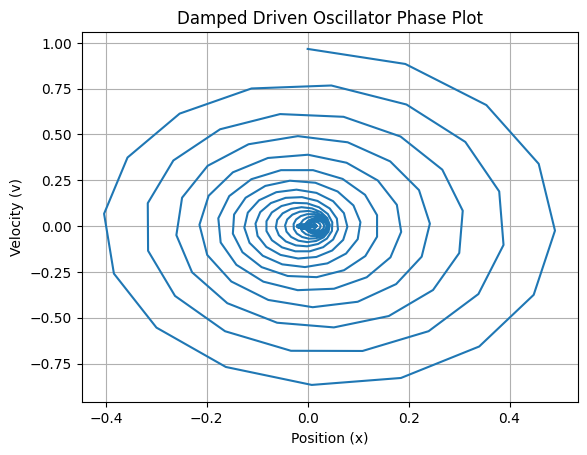

In [64]:
plt.figure()
plt.plot(Y1[0, :], np.gradient(Y1[0, :], t))
plt.title("Damped Driven Oscillator Phase Plot")
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
plt.grid(True)
plt.show()


## Training Modle

### BuckyNet

In [65]:
model3 = BuckyNet(X1, Y1, dim_matrix1, num_nondim=3, num_layers=2, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0,nullspace_loss = 0.0001)
loss = model3.loss()

print("loss",loss)

29/29 [==============================] - 0s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0267
loss [0.0013615653151646256, 0.026689311489462852]


### Control Model

In [19]:
model4 = NeuralNet(X1, Y1, num_layers=2, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=20, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0)

loss1 = model4.loss()

print("loss",loss1)

29/29 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1251
loss [0.016073230654001236, 0.12505415081977844]


### UMAP Output Results Training Control Modle

Dimensionality reduction

In [66]:
x3 = umap.UMAP(n_components=3).fit(X1)

x_trian3 = x3.embedding_

Training Modle

In [67]:
model6 = NeuralNet(x_trian3, Y1, num_layers=2, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0)

loss2 = model6.loss()

print("Cross-validation scores:", loss2)

29/29 [==============================] - 0s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0451
Cross-validation scores: [0.007952927611768246, 0.04510978236794472]


## Cross-validation performance

### BuckyNet

In [8]:
model3 = BuckyNet(X1, Y1, dim_matrix1, num_nondim=3, num_layers=2, num_neurons=40, activation='elu', initializer='he_normal', nepoch=300, patience=100, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.001, verbose=0, nullspace_loss = 0.0001)
scores3 = model3.cross_validate(n_splits=5)

print("Cross-validation scores:", scores3)

29/29 [==============================] - 0s 2ms/step - loss: 5.9744e-04 - root_mean_squared_error: 0.0169


29/29 [==============================] - 0s 3ms/step - loss: 7.2378e-04 - root_mean_squared_error: 0.0216


29/29 [==============================] - 0s 2ms/step - loss: 9.4452e-04 - root_mean_squared_error: 0.0242


29/29 [==============================] - 0s 2ms/step - loss: 6.5955e-04 - root_mean_squared_error: 0.0195


29/29 [==============================] - 0s 3ms/step - loss: 6.4920e-04 - root_mean_squared_error: 0.0194
Cross-validation scores: [[0.0005974369705654681, 0.016908222809433937], [0.000723783450666815, 0.021600797772407532], [0.0009445202304050326, 0.02424764819443226], [0.0006595464656129479, 0.019535666331648827], [0.0006491997628472745, 0.019356800243258476]]


### Control model

In [55]:
model4 = NeuralNet(X1, Y1, num_layers=2, num_neurons=40, activation='elu', initializer='he_normal', nepoch=300, patience=100, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.001, verbose=0)

scores4 = model4.cross_validate(n_splits=5)

print("Cross-validation scores:", scores4)

29/29 [==============================] - 0s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1562


29/29 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1315


29/29 [==============================] - 0s 4ms/step - loss: 0.0250 - root_mean_squared_error: 0.1571


29/29 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1387


29/29 [==============================] - 0s 4ms/step - loss: 0.0299 - root_mean_squared_error: 0.1715
Cross-validation scores: [[0.024690859019756317, 0.15617689490318298], [0.017758755013346672, 0.13151942193508148], [0.024973774328827858, 0.15707378089427948], [0.019706344231963158, 0.1387472152709961], [0.029876159504055977, 0.17152516543865204]]


## Verifying robustness and generalisation with noisy data

Multiple access to a whole new 6,000 pieces of data

In [68]:
nsamples = int(6e3)
tsteps = 1000
tend = 200
initial_condition = [0, 1]

R3 = DampedDrivenOscillator(nsamples=nsamples, tsteps=tsteps, tend=tend, initial_condition=initial_condition, seed = 99)
X3, Y3 = R3.get_data()

Adding Gaussian Noise

In [90]:
X_noise3 = X3 + np.random.normal(loc=0.0, scale=0.1, size=X3.shape)

###Buckynet

In [63]:
from sklearn.metrics import mean_squared_error

predictions1 = model4.model.predict(X3)

mse_value1 = mean_squared_error(predictions1, Y3)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

188/188 [==============================] - 1s 6ms/step
MSE 0.015555599901930315
RMSE 0.1247220906733459


In [82]:
from sklearn.metrics import mean_squared_error

predictions1 = model4.model.predict(X_noise3)

mse_value1 = mean_squared_error(predictions1, Y3)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

188/188 [==============================] - 0s 1ms/step
MSE 0.03171431538318681
RMSE 0.17808513521118716


### Control Model

In [21]:
from sklearn.metrics import mean_squared_error

predictions2 = model3.model.predict(X3)

mse_value2 = mean_squared_error(predictions2, Y3)
rmse_value2 = np.sqrt(mse_value2)

print("MSE",mse_value2)
print("RMSE",rmse_value2)

188/188 [==============================] - 1s 3ms/step
MSE 1.1218376617543497
RMSE 1.0591683821538245


In [79]:
from sklearn.metrics import mean_squared_error

predictions2 = model3.model.predict(X_noise3)

mse_value2 = mean_squared_error(predictions2, Y3)
rmse_value2 = np.sqrt(mse_value2)

print("MSE",mse_value2)
print("RMSE",rmse_value2)

188/188 [==============================] - 0s 2ms/step
MSE 1.358532107625173
RMSE 1.165560855393305


### UMAP

Dimensionality reduction

In [60]:
x4 = umap.UMAP(n_components=1).fit(X3)

x_trian4 = x4.embedding_

test_embedding4 = x4.transform(X_noise3)

x_test4 = test_embedding4

Raw Data

In [69]:
from sklearn.metrics import mean_squared_error

predictions6 = model6.model.predict(x_trian4)

mse_value6 = mean_squared_error(predictions6, Y3)
rmse_value6 = np.sqrt(mse_value6)

print("MSE",mse_value6)
print("RMSE",rmse_value6)

188/188 [==============================] - 1s 3ms/step
MSE 0.0069609288036329925
RMSE 0.08343218086345935


Noisy Data

In [68]:
from sklearn.metrics import mean_squared_error

predictions6 = model4.model.predict(x_test4)

mse_value6 = mean_squared_error(predictions6, Y3)
rmse_value6 = np.sqrt(mse_value6)

print("MSE",mse_value6)
print("RMSE",rmse_value6)

188/188 [==============================] - 1s 4ms/step
MSE 0.017235345647713857
RMSE 0.13128345534649008


### 60,000 data test

In [6]:
nsamples = int(6e4)
tsteps = 1000
tend = 200
initial_condition = [0, 1]

R10 = DampedDrivenOscillator(nsamples=nsamples, tsteps=tsteps, tend=tend, initial_condition=initial_condition, seed = 99)
X10, Y10 = R10.get_data()

In [7]:
X_noise10 = X10 + np.random.normal(loc=0.0, scale=0.2, size=X10.shape)

In [51]:
reducer = umap.UMAP(n_components=3)
x10 = reducer.fit_transform(X10)
reducer = umap.UMAP(n_components=3)
x_noise10 = reducer.fit_transform(X_noise10)

BuckyNet

In [75]:
from sklearn.metrics import mean_squared_error

predictions1 = model4.model.predict(X10)

mse_value1 = mean_squared_error(predictions1, Y10)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

1875/1875 [==============================] - 8s 4ms/step
MSE 0.01565771556438589
RMSE 0.12513079382944028


In [76]:
from sklearn.metrics import mean_squared_error

predictions1 = model4.model.predict(X_noise10)

mse_value1 = mean_squared_error(predictions1, Y10)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

1875/1875 [==============================] - 6s 3ms/step
MSE 0.017399247400349347
RMSE 0.13190620683026766


Control Model

In [77]:
from sklearn.metrics import mean_squared_error

predictions1 = model3.model.predict(X10)

mse_value1 = mean_squared_error(predictions1, Y10)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

1875/1875 [==============================] - 6s 3ms/step
MSE 1.1137750939078253
RMSE 1.055355434869137


In [78]:
from sklearn.metrics import mean_squared_error

predictions1 = model3.model.predict(X_noise10)

mse_value1 = mean_squared_error(predictions1, Y10)
rmse_value1 = np.sqrt(mse_value1)

print("MSE",mse_value1)
print("RMSE",rmse_value1)

1875/1875 [==============================] - 4s 2ms/step
MSE 1.35696153310831
RMSE 1.1648869185926631


UMAPNet

In [101]:
from sklearn.metrics import mean_squared_error

predictions6 = model6.model.predict(x10)

mse_value6 = mean_squared_error(predictions6, Y10)
rmse_value6 = np.sqrt(mse_value6)

print("MSE",mse_value6)
print("RMSE",rmse_value6)

1875/1875 [==============================] - 10s 5ms/step
MSE 0.01170609530899311
RMSE 0.10819471017102966


In [102]:
from sklearn.metrics import mean_squared_error

predictions6 = model6.model.predict(x_noise10)

mse_value6 = mean_squared_error(predictions6, Y10)
rmse_value6 = np.sqrt(mse_value6)

print("MSE",mse_value6)
print("RMSE",rmse_value6)

1875/1875 [==============================] - 5s 2ms/step
MSE 0.004863634797273935
RMSE 0.06973976482089637


## Data visualisation

### BuckyNet processed embedding space

Raw Data

In [95]:
from keras.models import Model

model20 = BuckyNet(X3, Y3, dim_matrix1, num_nondim=3, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0, nullspace_loss = 0.0001)

# Create a new model with output from Pi_layer
New_model20 = Model(inputs=model20.model.inputs,
                           outputs=model20.model.get_layer('pi_numbers').output)

# Use the new model to predict the input data and get the output of Pi_layer
Pi_outputs20 = New_model20.predict(model20.inputs_train)

pi1 = Pi_outputs20[:, 0:1]
pi2 = Pi_outputs20[:, 1:2]
pi3 = Pi_outputs20[:, 2:3]

136/136 [==============================] - 0s 1ms/step


Noisy Data

In [128]:
model21 = BuckyNet(X_noise3, Y3, dim_matrix1, num_nondim=3, num_layers=3, num_neurons=40, activation='elu', initializer='he_normal', nepoch=100, patience=50, test_size=0.15, l1_reg=0.00001, l2_reg=0.00001, adamlr=0.0001, verbose=0, nullspace_loss = 0.0001)

# Create a new model with output from Pi_layer
New_model21 = Model(inputs=model21.model.inputs,
                           outputs=model21.model.get_layer('pi_numbers').output)

# Use the new model to predict the input data and get the output of Pi_layer
Pi_outputs21 = New_model21.predict(model21.inputs_train)

pi1_noisy = Pi_outputs21[:, 0:1]
pi2_noisy = Pi_outputs21[:, 1:2]
pi3_noisy = Pi_outputs21[:, 2:3]

<ipython-input-30-900551f4a106>:22: RuntimeWarning: invalid value encountered in log
  train_test_split(np.log(inputs), outputs, test_size=test_size, shuffle=False)


136/136 [==============================] - 0s 1ms/step


Histogram

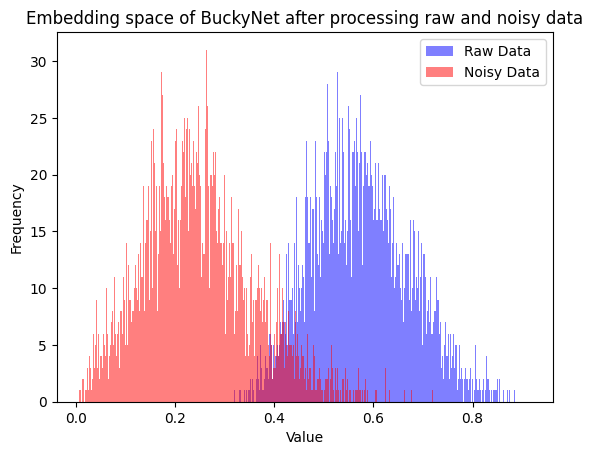

In [100]:
plt.hist(pi1, bins=500, alpha=0.5, label='Raw Data', color='blue')
plt.hist(pi1_noisy, bins=500, alpha=0.5, label='Noisy Data', color='red')

plt.legend(loc='upper right')

plt.title('Embedding space of BuckyNet after processing raw and noisy data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

<ipython-input-30-900551f4a106>:22: RuntimeWarning: invalid value encountered in log
  train_test_split(np.log(inputs), outputs, test_size=test_size, shuffle=False)


136/136 [==============================] - 0s 1ms/step


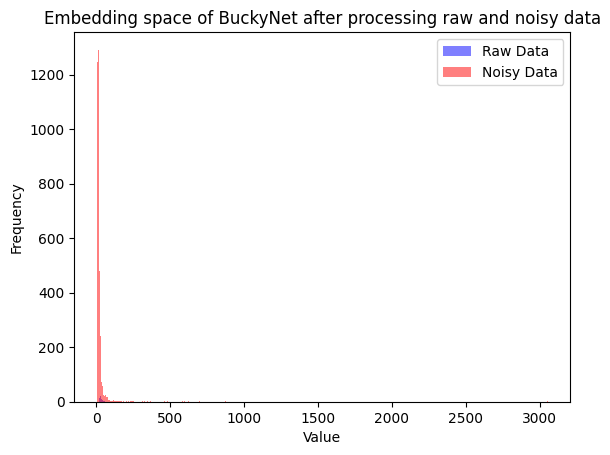

In [142]:
plt.hist(pi2, bins=500, alpha=0.5, label='Raw Data', color='blue')
plt.hist(pi2_noisy, bins=500, alpha=0.5, label='Noisy Data', color='red')

plt.legend(loc='upper right')

plt.title('Embedding space of BuckyNet after processing raw and noisy data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

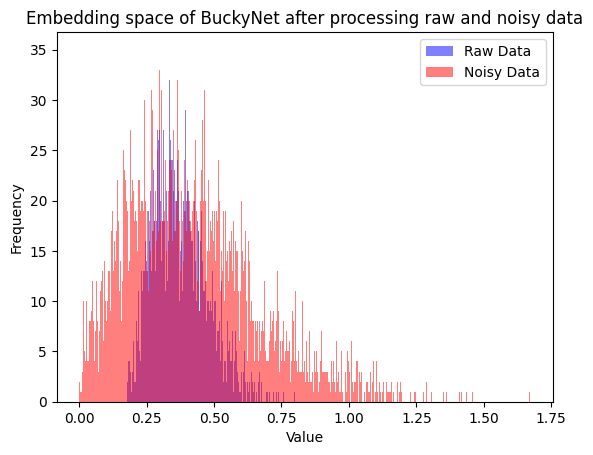

In [143]:
plt.hist(pi3, bins=500, alpha=0.5, label='Raw Data', color='blue')
plt.hist(pi3_noisy, bins=500, alpha=0.5, label='Noisy Data', color='red')

plt.legend(loc='upper right')

plt.title('Embedding space of BuckyNet after processing raw and noisy data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Embedding space after UMAP dimensionality reduction

In [146]:
x4 = umap.UMAP(n_components=3).fit(X3)

x_trian4 = x4.embedding_

test_embedding4 = x4.transform(X_noise3)

x_test4 = test_embedding4

Raw Data

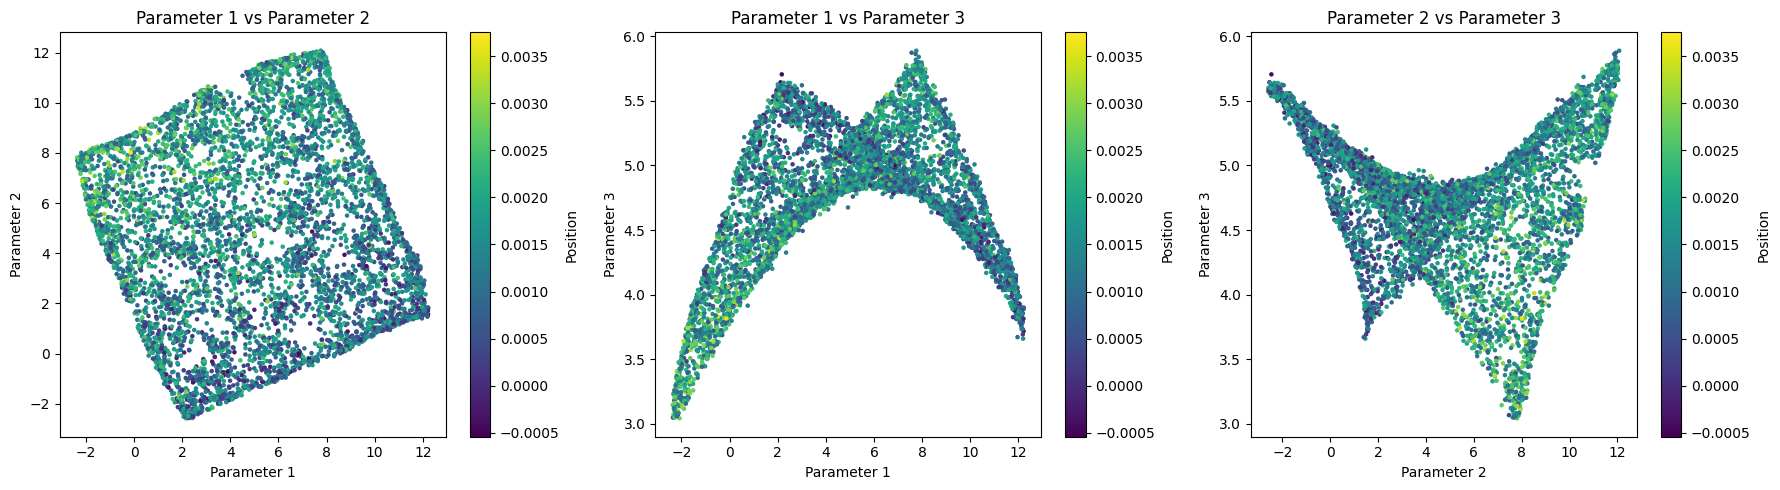

In [168]:
colors = np.mean(Y3, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Parameter 1 vs Parameter 2
sc1 = axs[0].scatter(x_test4[:, 0], x_test4[:, 1], c=colors, cmap='viridis', s=5)
axs[0].set_title('Parameter 1 vs Parameter 2')
axs[0].set_xlabel('Parameter 1')
axs[0].set_ylabel('Parameter 2')
plt.colorbar(sc1, ax=axs[0], label='Position')

# Parameter 1 vs Parameter 3
sc2 = axs[1].scatter(x_test4[:, 0], x_test4[:, 2], c=colors, cmap='viridis', s=5)
axs[1].set_title('Parameter 1 vs Parameter 3')
axs[1].set_xlabel('Parameter 1')
axs[1].set_ylabel('Parameter 3')
plt.colorbar(sc2, ax=axs[1], label='Position')

# Parameter 2 vs Parameter 3
sc3 = axs[2].scatter(x_test4[:, 1], x_test4[:, 2], c=colors, cmap='viridis', s=5)
axs[2].set_title('Parameter 2 vs Parameter 3')
axs[2].set_xlabel('Parameter 2')
axs[2].set_ylabel('Parameter 3')
plt.colorbar(sc3, ax=axs[2], label='Position')

plt.tight_layout()
plt.show()

Noisy Data

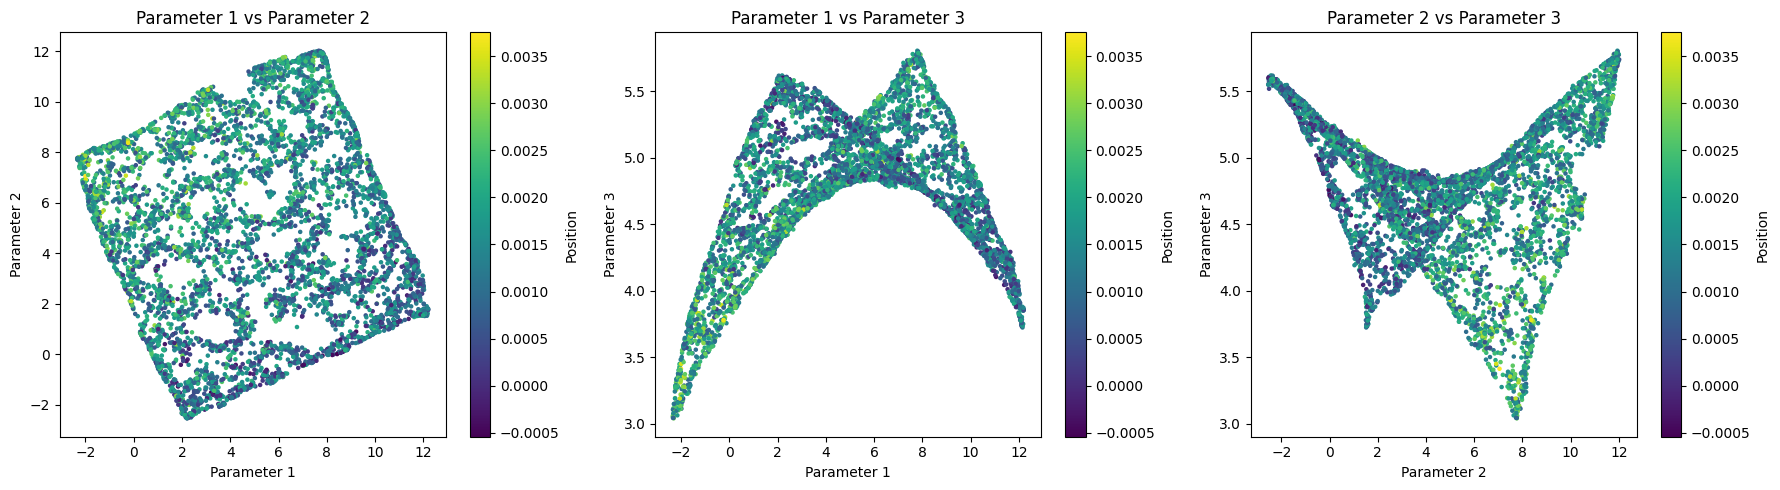

In [169]:
colors = np.mean(Y3, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Parameter 1 vs Parameter 2
sc1 = axs[0].scatter(x_trian4[:, 0], x_trian4[:, 1], c=colors, cmap='viridis', s=5)
axs[0].set_title('Parameter 1 vs Parameter 2')
axs[0].set_xlabel('Parameter 1')
axs[0].set_ylabel('Parameter 2')
plt.colorbar(sc1, ax=axs[0], label='Position')

# Parameter 1 vs Parameter 3
sc2 = axs[1].scatter(x_trian4[:, 0], x_trian4[:, 2], c=colors, cmap='viridis', s=5)
axs[1].set_title('Parameter 1 vs Parameter 3')
axs[1].set_xlabel('Parameter 1')
axs[1].set_ylabel('Parameter 3')
plt.colorbar(sc2, ax=axs[1], label='Position')

# Parameter 2 vs Parameter 3
sc3 = axs[2].scatter(x_trian4[:, 1], x_trian4[:, 2], c=colors, cmap='viridis', s=5)
axs[2].set_title('Parameter 2 vs Parameter 3')
axs[2].set_xlabel('Parameter 2')
axs[2].set_ylabel('Parameter 3')
plt.colorbar(sc3, ax=axs[2], label='Position')

plt.tight_layout()
plt.show()